In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import random
import shutil
from PIL import Image
import matplotlib.patches as mpatches
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_predict
import math
from sklearn.model_selection import KFold

In [2]:
N1 = 69225 % 2
N1

1

In [3]:
N1 = 699531 % 2
N1

1

### Calculando a área da Celula

In [4]:
def calculaAreaPerimetroImagem(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  mascara_colorida = np.zeros_like(img_cv2)
  cv2.drawContours(mascara_colorida, contornos, -1, (255, 255, 255), thickness=cv2.FILLED)

  # Exibir a imagem original, a máscara e a parte colorida
  area_branca = np.sum(mascara_binaria == 255)
  
  
  total_perimetro = 0
  
  for contorno in contornos:
    perimeter = cv2.arcLength(contorno, closed=True)
    total_perimetro += perimeter
  
  return area_branca, round(total_perimetro, 2)


### Calculando Compacidade

In [5]:
# perimetro^2 / 4 PI area
def calcularCompacidade(img_cv2):
  area, perimetro = calculaAreaPerimetroImagem(img_cv2)
  
  compacidade = (perimetro**2) / (area * (4 * math.pi)) 
  
  return round(compacidade, 4)

### Calculando Excentricidade

In [7]:
def calcularExcentricidades(img_cv2):
  
  imagem_cinza = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
  _, mascara_binaria = cv2.threshold(imagem_cinza, 1, 255, cv2.THRESH_BINARY)
  contornos, _ = cv2.findContours(mascara_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  maior_contorno = max(contornos, key=cv2.contourArea)

    
  if len(maior_contorno) >= 5:
    # (elipse_x, elipse_y), (eixo_maior, eixo_menor), _ = cv2.fitEllipse(maior_contorno)
    elipse = cv2.fitEllipse(maior_contorno)
    eixo_maior = max(elipse[1])
    eixo_menor = min(elipse[1])
    # Restante do seu código
  else:
    return 0


  # Calcular excentricidade
  # 1-menor^2 / 1-maior^2
  
  excentricidade = 1 - ((eixo_menor ** 2) / (eixo_maior ** 2))
  
  # if(eixo_maior != 0 and eixo_menor != 0):
  #   value_mid = round((eixo_menor / eixo_maior)**2, 2)
  # else:
  #   return 0
  
  # excentricidade = round(np.sqrt(value_mid-1),2)
  
  return excentricidade

### Gerar CSV

In [163]:
csv = {'id_cel': [],
       'label': [],
       'area': [],
       'compacidade': [],
       'excentricidade': [],
       }

path_dataset_segmentation = "../data/segmentation_dataset_balanceado/"


for pasta_atual, subpastas, arquivos in os.walk(path_dataset_segmentation):
    for arquivo in arquivos:
        caminho_completo = os.path.join(pasta_atual, arquivo)
        
        imagem = cv2.imread(caminho_completo)
        
        
        area, _ = calculaAreaPerimetroImagem(imagem)
        
        nomeSplit = caminho_completo.split("\\")
        classeSpli = nomeSplit[0].split("/")
        nomeCel = nomeSplit[1].replace(".png", "")
        nomeClasse = classeSpli[len(classeSpli)-1]
        csv['id_cel'].append(nomeCel)

        
        csv['area'].append(round(area,2))
        csv['label'].append(nomeClasse)
        csv['compacidade'].append(calcularCompacidade(imagem))
        csv['excentricidade'].append(calcularExcentricidades(imagem))
          
  
       
df = pd.DataFrame(csv)
df.to_csv('../csv_pt2_categorical.csv', index=False)       


In [9]:
df = pd.read_csv("../csv_pt2_categorical.csv")

### Normalizar CSV

In [177]:
from sklearn.preprocessing import MinMaxScaler
# Carregue o CSV para um DataFrame
df = pd.read_csv('../csv_pt2_categorical.csv')

# Selecione apenas as colunas que você deseja normalizar
colunas_para_normalizar = ['area', 'compacidade', 'excentricidade']
dados_normalizar = df[colunas_para_normalizar]

# Inicialize o objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajuste e transforme os dados
dados_normalizados = scaler.fit_transform(dados_normalizar)

# Substitua as colunas no DataFrame pelos dados normalizados
df[colunas_para_normalizar] = dados_normalizados

# Agora, df contém os dados normalizados
# Você pode salvar o DataFrame de volta em um novo arquivo CSV se desejar
df.to_csv('../csv_pt2_categorical.csv', index=False)

### Gerando scatterplot com as caracteristicas calculadas

#### Area X Compacidade

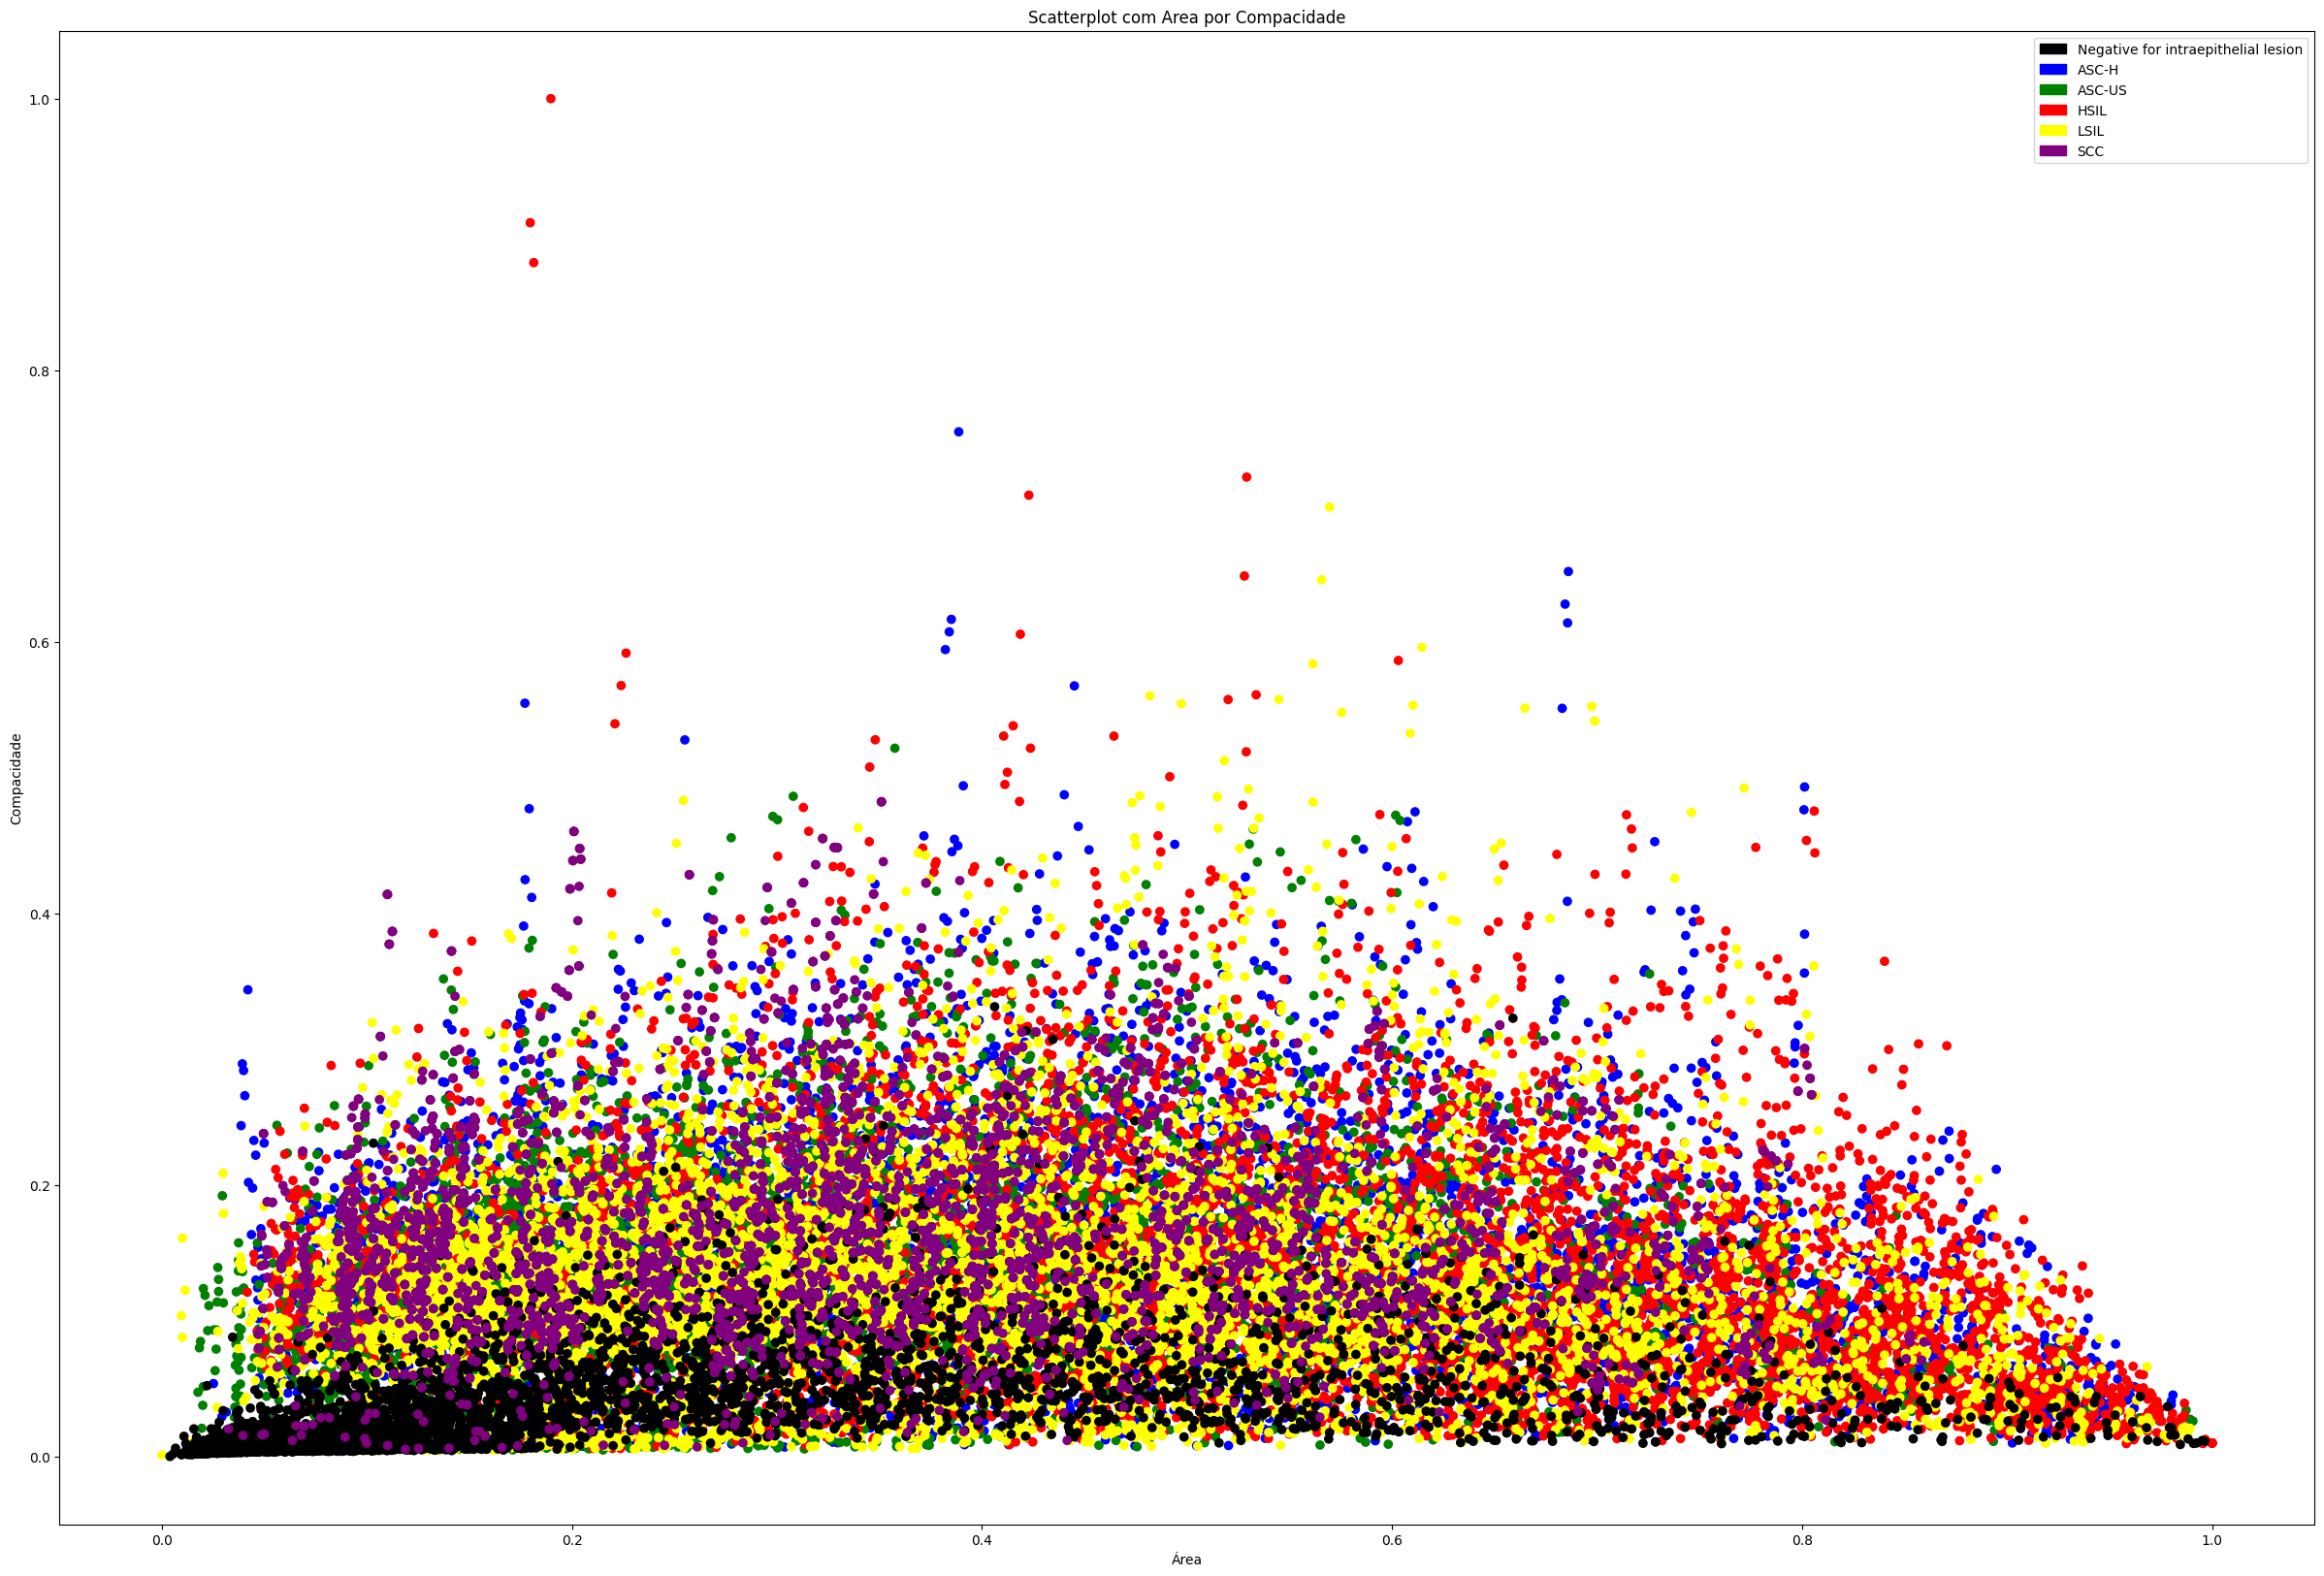

In [178]:
cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}
# cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df['Cor'] = df['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df['area'], df['compacidade'], c=df['Cor'], label=df['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Compacidade')
plt.title('Scatterplot com Area por Compacidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

#### Area x Excentricidade

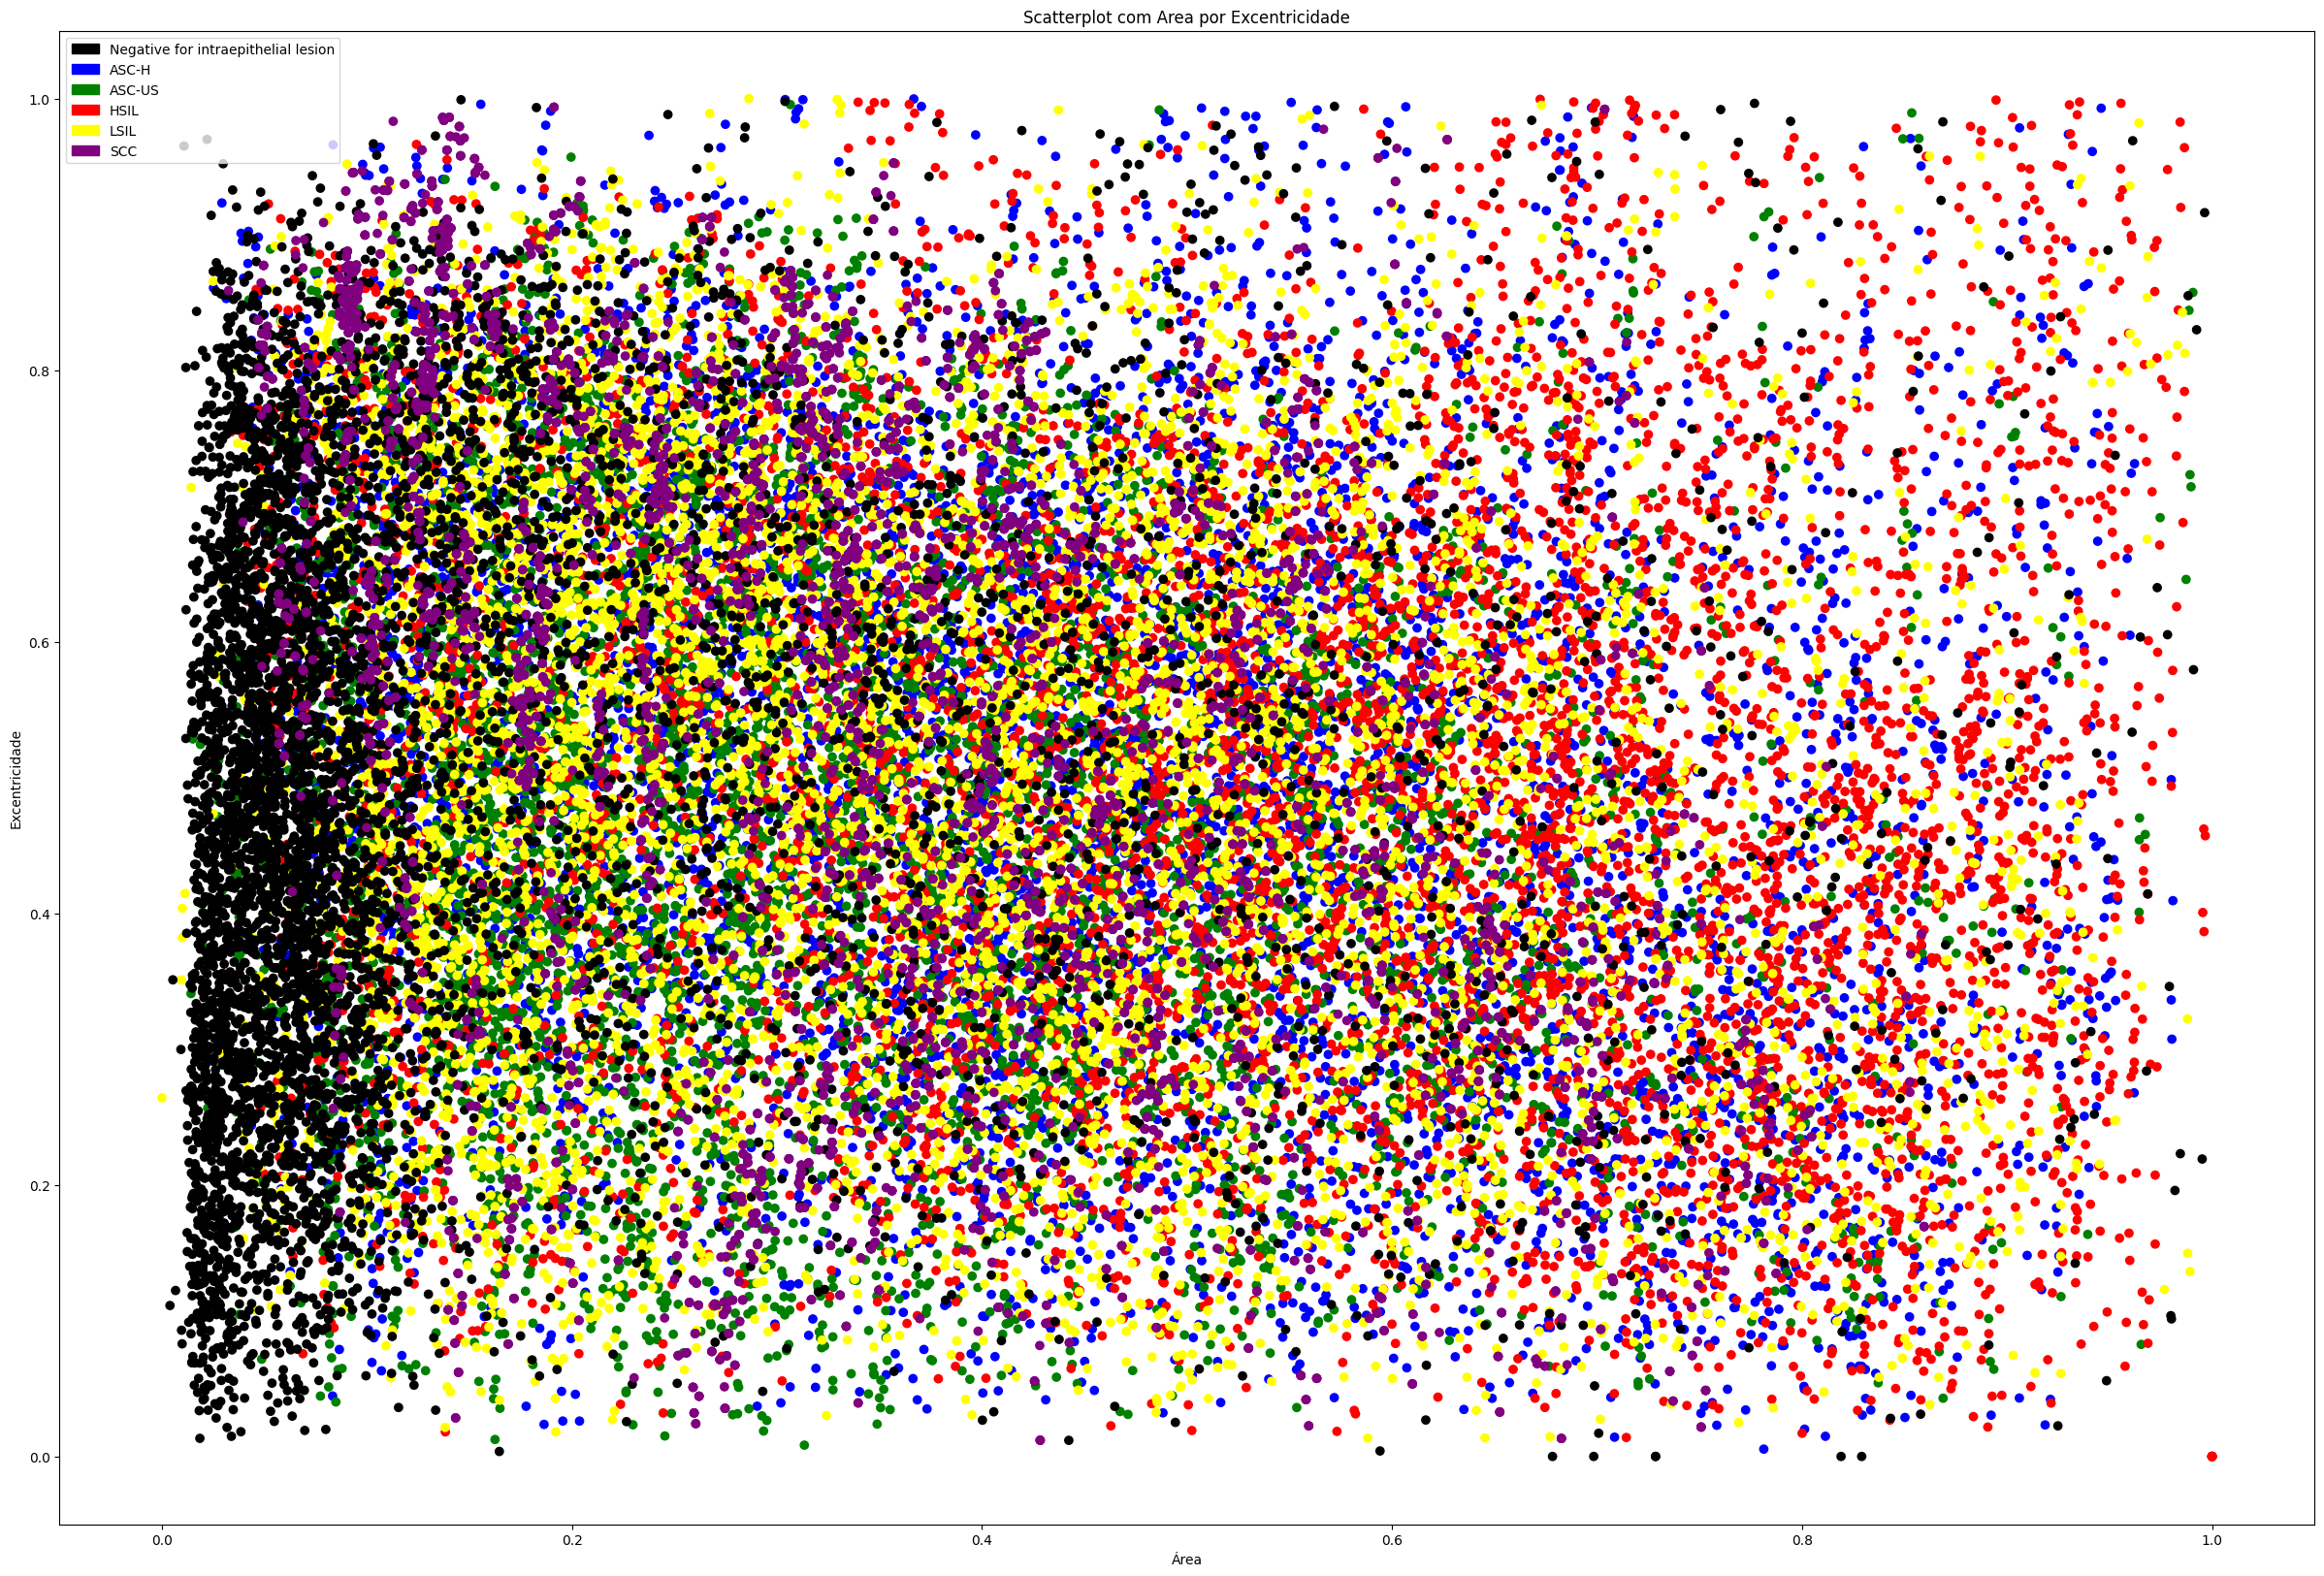

In [179]:
# df = pd.read_csv('csv_pt2.csv')
# df = pd.read_csv('csv_pt2_binario.csv')

# df_filter = df[df["excentricidade"]<10 ]
df_filter = df

cores = {'Negative for intraepithelial lesion': 'black', 'ASC-H': 'blue', "ASC-US":"green", 'HSIL': 'red', 'LSIL': 'yellow','SCC': 'purple',}
# cores = {'Negativo': 'black', 'Positivo': 'blue'}

# Adicionar uma coluna 'Cor' com as cores correspondentes às classes
df_filter['Cor'] = df_filter['label'].map(cores)
plt.figure(figsize=(30, 20))

# Plotar o scatterplot
plt.scatter(df_filter['area'], df_filter['excentricidade'], c=df_filter['Cor'], label=df_filter['label'])

# Tamanho da Figura

# Adicionar rótulos e título
plt.xlabel('Área')
plt.ylabel('Excentricidade')
plt.title('Scatterplot com Area por Excentricidade')

# Criando patches das legendas
patches = [mpatches.Patch(color=color, label=label) for label, color in cores.items()]

# intervalos_y = [15, 25, 55, 115, 125, 155, 215, 225, 255, 315, 325, 355, 415, 425, 455, 515, 525, 555]
# plt.yticks(intervalos_y)
# Adicionar uma legenda
plt.legend(handles=patches)

# Exibir o gráfico
plt.show()

### Dividindo o dataset em treino e teste

In [ ]:
def obter_nomes_pastas(diretorio):
    nomes_pastas = []
    for nome in os.listdir(diretorio):
        if os.path.isdir(os.path.join(diretorio, nome)):
            nomes_pastas.append(nome)
    return nomes_pastas
  
  
# Exemplo de uso
cwd = os.getcwd()


diretorio = cwd + "/data/segmentation_dataset/"
pastas = obter_nomes_pastas(diretorio)

diretorio_origem = diretorio
diretorio_destino = cwd + '/data/segentation_dataset_treino/'

percent = 0.8

for each in pastas:

    # Diretório contendo todas as imagens
    diretorio_imagens = diretorio_origem + f'/{each}/'

    # Diretório para salvar as imagens de treinamento
    diretorio_treinamento = diretorio_destino + f'/train/{each}/'

    # Diretório para salvar as imagens de teste
    diretorio_teste = diretorio_destino + f'/test/{each}/'

    # Lista todas as imagens no diretório
    imagens = os.listdir(diretorio_imagens)

    # Embaralha a lista de imagens
    random.shuffle(imagens)

    # Calcula o índice para dividir as imagens
    indice_divisao = int(percent * len(imagens))

    # Separa as imagens em treinamento e teste
    imagens_treinamento = imagens[:indice_divisao]
    imagens_teste = imagens[indice_divisao:]

    if not (os.path.exists(diretorio_teste)):
        os.makedirs(diretorio_teste)

    if not (os.path.exists(diretorio_treinamento)):
        os.makedirs(diretorio_treinamento)

    # Move as imagens para os diretórios correspondentes
    for imagem in imagens_treinamento:
        shutil.copy(os.path.join(diretorio_imagens, imagem),
                    diretorio_treinamento)

    for imagem in imagens_teste:
        shutil.copy(os.path.join(diretorio_imagens, imagem), diretorio_teste)



### Calculando Mahalanobis 6 Classes

In [180]:
df = pd.read_csv('../csv_pt2_categorical.csv')
df

id_cel  label      area  compacidade  excentricidade
0                             10  ASC-H  0.259978     0.084798        0.594494
1                          10000  ASC-H  0.103348     0.025732        0.867566
2      10000_flip_horizontal.jpg  ASC-H  0.121745     0.131913        0.845539
3        10000_flip_vertical.jpg  ASC-H  0.124862     0.180617        0.842064
4             10000_rotate_0.jpg  ASC-H  0.123354     0.182573        0.840684
...                          ...    ...       ...          ...             ...
39645           96_rotate_90.jpg    SCC  0.160249     0.174530        0.817650
39646          96_rotate_900.jpg    SCC  0.162662     0.196440        0.841200
39647          96_rotate_930.jpg    SCC  0.162059     0.149917        0.830044
39648          96_rotate_960.jpg    SCC  0.163165     0.133022        0.833935
39649          96_rotate_990.jpg    SCC  0.157535     0.133447        0.877467

[39650 rows x 5 columns]

In [181]:
# Dividindo em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [182]:
train_df

id_cel   label      area  compacidade  excentricidade
35033       7619_rotate_510.jpg     SCC  0.335679     0.056747        0.536361
22568        2390_rotate_30.jpg    LSIL  0.357595     0.238346        0.593218
38260       7926_rotate_390.jpg     SCC  0.275661     0.096909        0.113447
19841         9485_rotate_0.jpg    HSIL  0.489896     0.203315        0.491499
904    2007_flip_horizontal.jpg   ASC-H  0.613250     0.056737        0.193244
...                         ...     ...       ...          ...             ...
6265                       9936   ASC-H  0.099326     0.007168        0.575845
11284    4929_flip_vertical.jpg  ASC-US  0.621997     0.149719        0.260264
38158         78_rotate_750.jpg     SCC  0.069468     0.141911        0.702547
860          2000_rotate_90.jpg   ASC-H  0.781542     0.076497        0.228758
15795    8077_flip_vertical.jpg    HSIL  0.389665     0.245797        0.479295

[31720 rows x 5 columns]

In [183]:
def calcular_estatisticas_por_classe(df):
    estatisticas_por_classe = {}
    for classe in df['label'].unique():
        classe_df = df[df['label'] == classe]
        
        # Converta as colunas para números
        numeric_columns = ['area', 'compacidade', 'excentricidade']
        for col in numeric_columns:
            classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
        
        estatisticas_por_classe[classe] = {
            'media': np.mean(classe_df[numeric_columns], axis=0),
            'covariancia': np.cov(classe_df[numeric_columns], rowvar=False)
        }
    return estatisticas_por_classe
# Calcule as estatísticas para o conjunto de treinamento
estatisticas_treinamento = calcular_estatisticas_por_classe(train_df)


for each in estatisticas_treinamento.items():
  print(each)

('SCC', {'media': area              0.348593
compacidade       0.168692
excentricidade    0.537230
dtype: float64, 'covariancia': array([[ 0.03341361,  0.00048585, -0.0174592 ],
       [ 0.00048585,  0.00538601,  0.00137032],
       [-0.0174592 ,  0.00137032,  0.05302486]])})
('LSIL', {'media': area              0.386551
compacidade       0.125390
excentricidade    0.499570
dtype: float64, 'covariancia': array([[ 0.04684703,  0.00058424, -0.00716435],
       [ 0.00058424,  0.00624908, -0.00054676],
       [-0.00716435, -0.00054676,  0.04239124]])})
('HSIL', {'media': area              0.542555
compacidade       0.132025
excentricidade    0.493592
dtype: float64, 'covariancia': array([[ 0.05841049, -0.00340239, -0.0064321 ],
       [-0.00340239,  0.00798352, -0.00259209],
       [-0.0064321 , -0.00259209,  0.04548507]])})
('ASC-H', {'media': area              0.453874
compacidade       0.139264
excentricidade    0.498309
dtype: float64, 'covariancia': array([[ 0.05053952, -0.00195718, -

C:\Users\Viny\AppData\Local\Temp\ipykernel_37880\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\Viny\AppData\Local\Temp\ipykernel_37880\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classe_df[col] = pd.to_numeric(classe_df[col], errors='coerce')
C:\Users\Viny\AppData\Local\Temp\ipykernel_37880\955804924.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Acurácia: 0.37364438839848674
Matriz de Confusão:
[[  50  184  624  112   79  287]
 [  57  404  313  149   99  307]
 [  28  117  834   76   72  175]
 [  40  235  515  155  154  276]
 [   8   48  163  101 1004   20]
 [  37  178  367  120   26  516]]


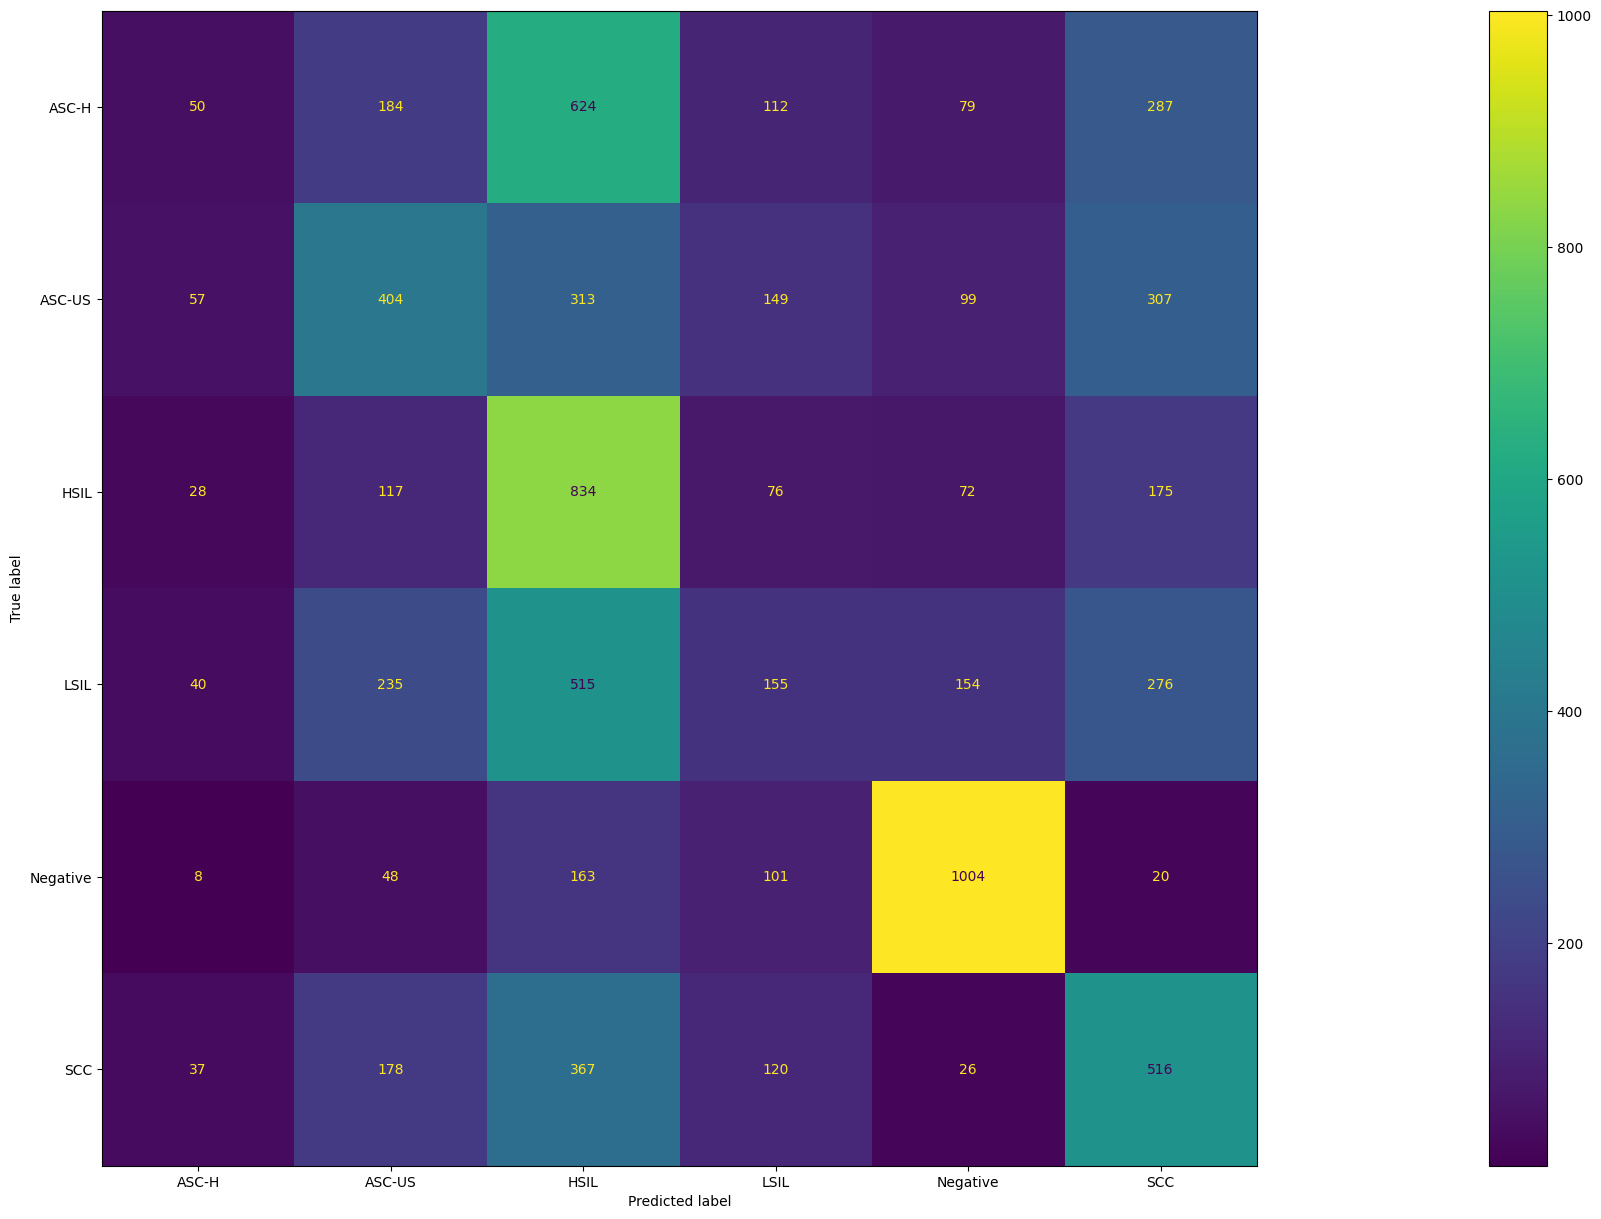

In [184]:
from scipy.spatial.distance import mahalanobis

# Função para classificar uma amostra usando distância de Mahalanobis
def classificar_mahalanobis(amostra, estatisticas_por_classe):
    distancias = {}
    for classe, estatisticas in estatisticas_por_classe.items():
        distancias[classe] = mahalanobis(amostra, estatisticas['media'], np.linalg.inv(estatisticas['covariancia']))
    return min(distancias, key=distancias.get)


test_df['predicao_mahalanobis'] = test_df[['area', 'compacidade', 'excentricidade']].apply(
    lambda x: classificar_mahalanobis(x, estatisticas_treinamento),
    axis=1
)


# Acurácia
acuracia = accuracy_score(test_df['label'], test_df['predicao_mahalanobis'])
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
matriz_confusao = confusion_matrix(test_df['label'], test_df['predicao_mahalanobis'])

y_true = test_df['label']
y_pred = test_df['predicao_mahalanobis']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)


labels = ["ASC-H", "ASC-US", "HSIL", "LSIL", "Negative", "SCC"] # Substitua pelo seu conjunto específico de rótulos
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)

### Cross Validation Mahanalobis

In [171]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import mahalanobis
class MahalanobisClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estatisticas_por_classe):
        self.estatisticas_por_classe = estatisticas_por_classe

    def fit(self, X, y=None):
        return self  # Não é necessário treinamento separado

    def predict(self, X):
        y_pred = []

        for _, amostra in X.iterrows():
            distancias = {}

            for classe, estatisticas in self.estatisticas_por_classe.items():
                distancias[classe] = mahalanobis(
                    amostra[['area', 'compacidade', 'excentricidade']],
                    estatisticas['media'],
                    np.linalg.inv(estatisticas['covariancia'])
                )

            predicao = min(distancias, key=distancias.get)
            y_pred.append(predicao)

        return y_pred

Acurácia: 0.37364438839848674
Matriz de Confusão:
[[  50  184  624  112   79  287]
 [  57  404  313  149   99  307]
 [  28  117  834   76   72  175]
 [  40  235  515  155  154  276]
 [   8   48  163  101 1004   20]
 [  37  178  367  120   26  516]]


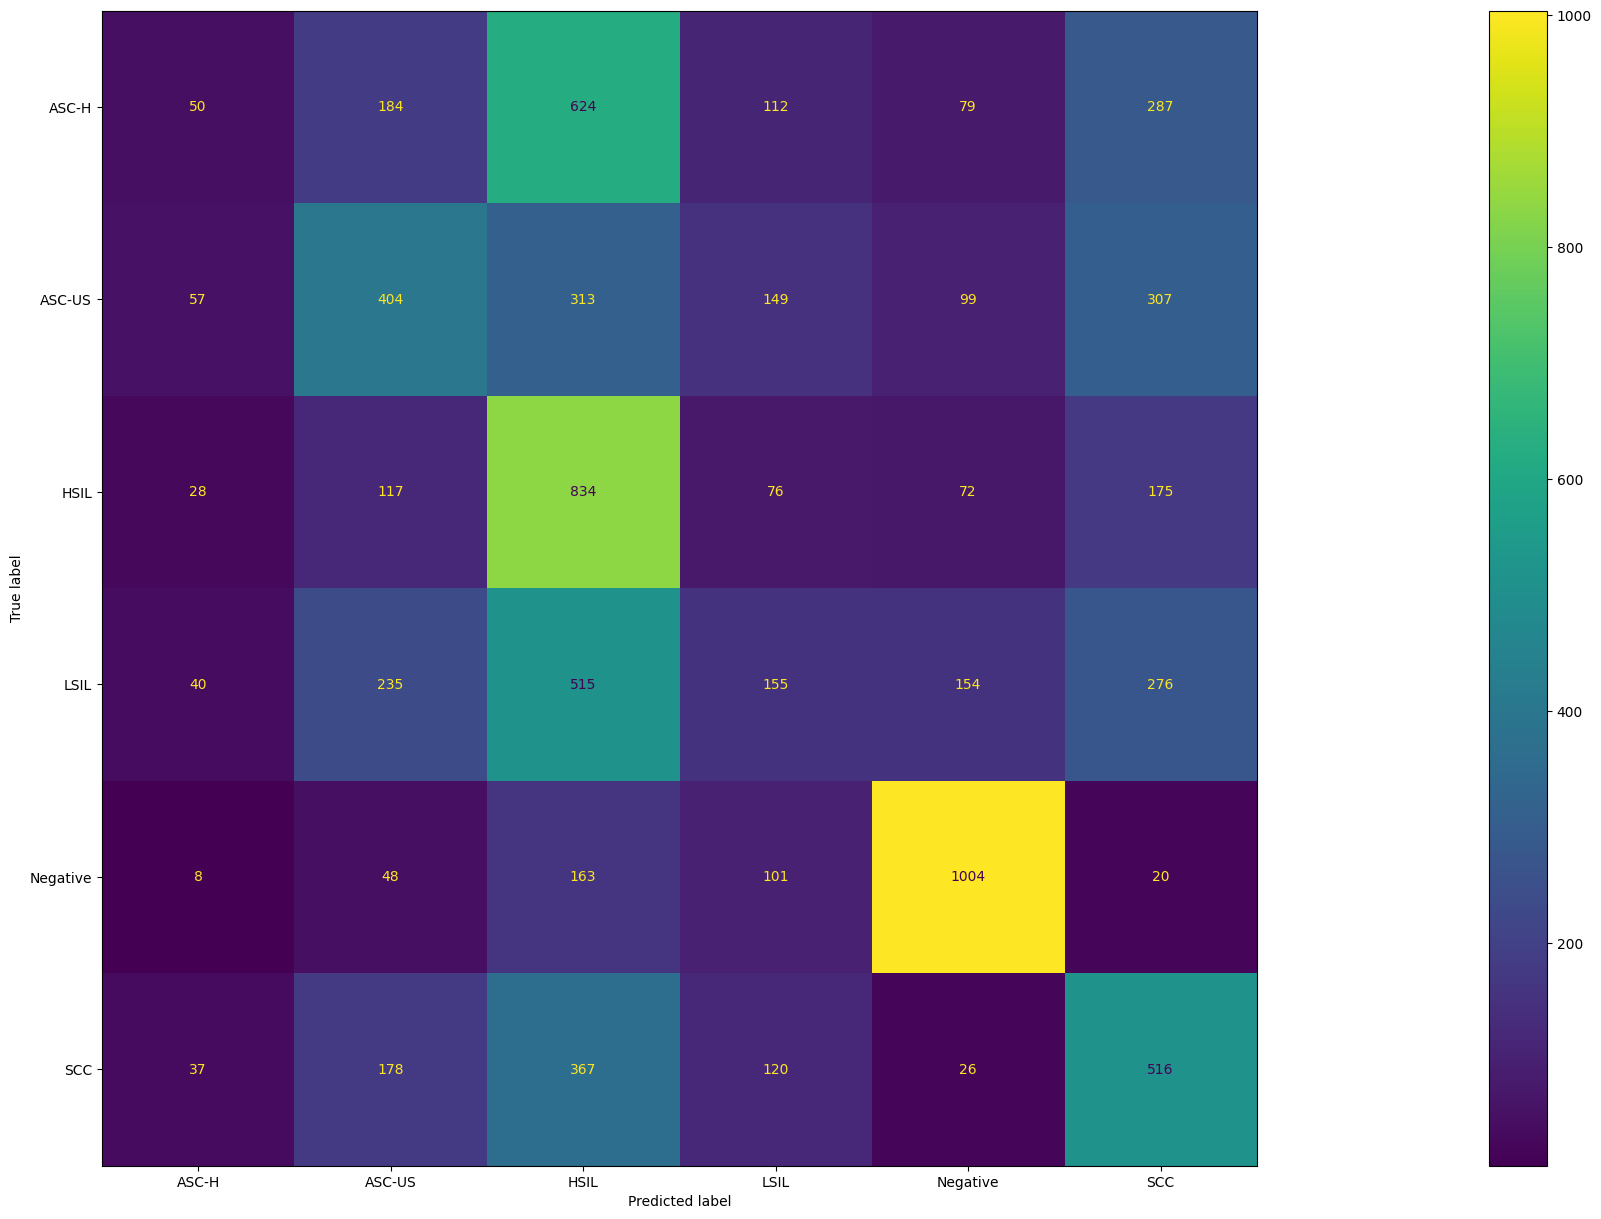

In [175]:
mahalanobis_estimator = MahalanobisClassifier(estatisticas_por_classe=estatisticas_treinamento)


y_pred = cross_val_predict(mahalanobis_estimator, 
                            X=test_df[['area', 'compacidade', 'excentricidade']],  # Conjunto de teste
                            y=test_df['label'], 
                            cv=6)  # Número de folds para a validação cruzada

# Acurácia
acuracia = accuracy_score(test_df['label'], y_pred=y_pred)
print(f'Acurácia: {acuracia}')

# Matriz de Confusão
y_true = test_df['label']

# Calcule a matriz de confusão
matriz_confusao = confusion_matrix(y_true, y_pred)

# Imprima a matriz de confusão
print('Matriz de Confusão:')
print(matriz_confusao)



labels = ["ASC-H", "ASC-US", "HSIL", "LSIL", "Negative", "SCC"]
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=labels)
fig, ax = plt.subplots(figsize=(60,15))
disp.plot(ax=ax)


### Balanceando dataset

In [ ]:
from tqdm import tqdm

def aumentar_dados(dataset_path, output_path, angulos):
    # Certifique-se de que o diretório de saída exista
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Lista todos os arquivos de imagem no diretório de entrada
    imagens = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Itera sobre as imagens e gera a quantidade desejada de novos dados
    for imagem_nome in tqdm(imagens, desc='Aumentando dados'):
        imagem_path = os.path.join(dataset_path, imagem_nome)
        img = cv2.imread(imagem_path)

        # Espelha horizontal
        img_flip_horizontal = cv2.flip(img, 1)
        salvar_imagem(output_path, imagem_nome, 'flip_horizontal', img_flip_horizontal)

        # Espelha verticalmente
        img_flip_vertical = cv2.flip(img, 0)
        salvar_imagem(output_path, imagem_nome, 'flip_vertical', img_flip_vertical)
        
        for angulo in angulos:
            # Gira a imagem conforme o ângulo especificado
            img_rotacionada = rotacionar_imagem(img, angulo)
            salvar_imagem(output_path, imagem_nome, f'rotate_{angulo}', img_rotacionada)

def rotacionar_imagem(imagem, angulo):
    altura, largura = imagem.shape[:2]
    ponto_rotacao = (largura // 2, altura // 2)
    matriz_rotacao = cv2.getRotationMatrix2D(ponto_rotacao, angulo, 1.0)
    imagem_rotacionada = cv2.warpAffine(imagem, matriz_rotacao, (largura, altura), flags=cv2.INTER_LINEAR)
    return imagem_rotacionada

def salvar_imagem(output_path, original_nome, operacao, imagem):
    # Cria o nome do arquivo para a imagem gerada
    novo_nome = f"{os.path.splitext(original_nome)[0]}_{operacao}.jpg"
    novo_path = os.path.join(output_path, novo_nome)

    # Salva a imagem gerada
    cv2.imwrite(novo_path, imagem)
    
    
dataset_path = '../data/segmentation_dataset_balanceado/SCC/'
output_path = '../data/segmentation_dataset_balanceado/SCC/'
angulos = [30 * i for i in range(10)] 
print(angulos)
aumentar_dados(dataset_path, output_path, angulos=angulos)